# Time Series Analysis of 911 calls

## Source
The original notebook was downloaded from a [Toward Data Science](https://towardsdatascience.com/how-to-add-fourier-terms-to-your-regression-seasonality-analysis-using-python-scipy-99a94d3ae51) article by Lakshay Akula. I've adapted the source to add some graphs and notes that assisted me in understanding the analysis.

## Library imports

In [1]:
from scipy import fft
from scipy import signal as sig
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import warnings
warnings.simplefilter('ignore')

## Data imports

Source data from [Kaggle](https://www.kaggle.com/datasets/mchirico/montcoalert)

In [2]:
# Read & prep data
df = pd.read_csv('./data/911.csv')
# lc all column names
df = df.rename(columns = {k:k.lower() for k in df.columns})
# convert column to pandas timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])
# create column that is base hour of timestamp
df['timestamp_trunc'] = df['timestamp'].dt.floor('H')
df['N'] = 1

# Count calls per hour
counts = df.groupby(['timestamp_trunc']).sum()
counts = counts[['N']]
# dict of hourly (by date) timestamp to count of calls for that hour and date
counts_dict = counts['N'].to_dict()

## Dataframe

In [3]:
# Create a new DF with time & signal, filling in missing hours with 0 calls
data = pd.DataFrame()
# full range of hours in time span (counts only has data if calls came in)
data['time'] = pd.date_range(min(counts.index), max(counts.index), freq = 'H')
data.set_index('time')
# elapsed time in seconds from earliest date in X
data['time_sec'] = (data.time - min(data.time)).dt.total_seconds()
# signal is how many calls were made in that hour (zero if no value from X)
data['signal'] = data.time.apply(lambda x: counts_dict[x] if x in counts_dict.keys() else 0)

X = pd.DataFrame(data['time_sec']) 
y = pd.DataFrame(data['signal']) 

## First model - Simple Linear Regression (calculating residuals)

Here we take the difference of the X signals and the signals predicted by linear regression to get residuals.

In [4]:
model = LinearRegression()
model.fit(X, y) 
data['pred_signal_linreg'] = model.predict(X)
# X (corrected with all hours in date range) minus predicted X
data['residuals'] = data['signal'] - data['pred_signal_linreg']

# hours by date for entire date range
time = data['time']
residuals = data['residuals']

residuals.sample(5)

6421     -8.439985
821       7.515380
14797   -13.373225
1802      6.523199
17951     3.651914
Name: residuals, dtype: float64

R-squared is the percentage of variation (i.e. varies from 0 to 1) explained by the relationship between two variables (the difference in variation between a line of best fit and than the sample mean). 

In [5]:
print('Slope: {:.2e}, Intercept: {:.2f}'.format(model.coef_[0,0], model.intercept_[0]))
print('R-squared: {:.2e}'.format(model.score(X,y)))

Slope: -2.21e-09, Intercept: 16.49
R-squared: 7.75e-05


So the call volume starts at ~16.5 calls per hour, and every year the call volume goes down by about $−2e^{−9} \times 60 \times 60 \times 24 \times 365 ≈ 0.06$ calls per hour. This is unexpected, since the population has grown over the duration of the data set.

However, $R^2$ error is really bad. Let's look at the plot of residuals:

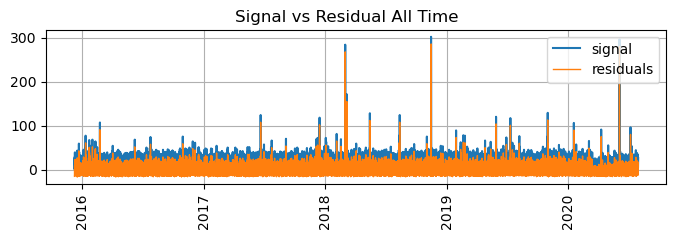

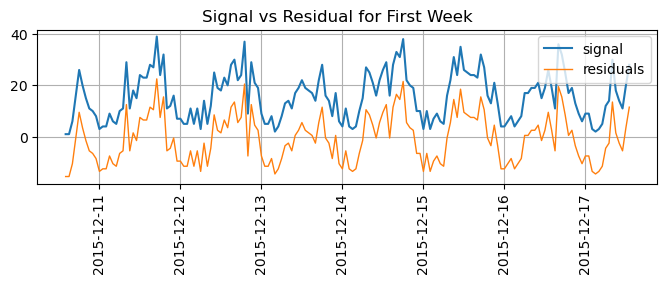

In [6]:
# All time
plt.figure(figsize=(8, 2))
plt.plot(time, data['signal'], label='signal')
plt.plot(time, residuals, linewidth=1, label='residuals')
plt.legend(loc='upper right')
plt.suptitle('Signal vs Residual All Time')
plt.grid()
plt.xticks(rotation=90);

# First week
N = 24 * 7 # seven days
plt.figure(figsize=(8, 2))
plt.plot(time[:N], data['signal'][:N], label='signal')
plt.plot(time[:N], residuals[:N], linewidth=1, label='residuals')
plt.legend(loc='upper right')
plt.suptitle('Signal vs Residual for First Week')
plt.grid()
plt.xticks(rotation=90);

We can still see some clear seasonality at the level of the first week plot. So the linear regression didn't filter out any seasonality effects.

## Second Model - Fourier transform & inverse Fourier transform

Here we are going to use the seasonality of the signal data to improve model predictions. We’ll use the Fourier transform to find the most dominant frequencies and then use the inverse Fourier transform to give us the functions that correspond to these frequencies.

Here are the dominant frequencies we find after the Fourier transform.

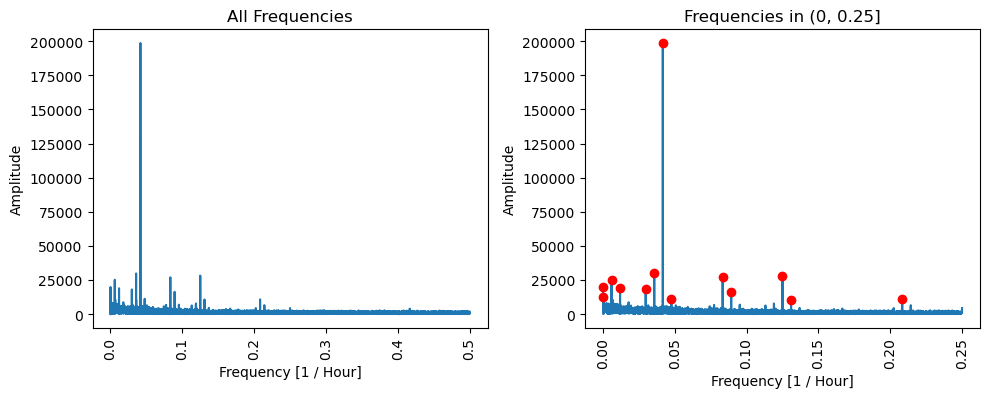

In [7]:
# Calculate FFT on residuals from LR model
fft_output = fft.fft(np.array(residuals)) # fft takes numpy array
power = np.abs(fft_output) # plotting power in the frequency domain
freq = fft.fftfreq(len(residuals))

mask = freq >= 0
freq = freq[mask]
power = power[mask]

plt.figure( figsize=(10, 4) )

ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(freq, power, label='residuals')
ax1.set_title('All Frequencies')
ax1.set_ylabel( 'Amplitude' )
ax1.set_xlabel( 'Frequency [1 / Hour]' )
plt.xticks(rotation=90)

ax2 = plt.subplot( 1, 2, 2 )
mask = (freq > 0) & (freq <= 0.25)
ax2.plot(freq[mask], power[mask])
ax2.set_title('Frequencies in (0, 0.25]')
ax2.set_ylabel( 'Amplitude' )
ax2.set_xlabel( 'Frequency [1 / Hour]' )

# peaks are index of prominent signals - will be used to filter residuals
peaks = sig.find_peaks(power[freq >=0], prominence=10**4)[0]
peak_freq =  freq[peaks]
peak_power = power[peaks]
plt.plot(peak_freq, peak_power, 'ro')

plt.tight_layout()
plt.xticks(rotation=90);

Here are the values these peaks correspond to.

In [8]:
from cmath import phase

fourier_terms = pd.DataFrame()
fourier_terms['fft'] = fft_output[peaks]
fourier_terms['freq (1 / hour)'] = peak_freq
# amplitude is abs(fft)
fourier_terms['amplitude'] = fourier_terms.fft.apply(lambda z: abs(z)) 
fourier_terms['phase'] = fourier_terms.fft.apply(lambda z: phase(z))
# period is 1/freq
fourier_terms['period (days)'] = 1 / peak_freq / 24
fourier_terms.sort_values(by=['amplitude'], ascending=False, inplace=True)

# Create some helpful labels (FT_1..FT_N)
fourier_terms['label'] = list(map(lambda n : 'FT_{}'.format(n), range(1, len(fourier_terms) + 1)))

# Turn our dataframe into a dictionary for easy lookup
fourier_terms = fourier_terms.set_index('label')
fourier_terms_dict = fourier_terms.to_dict('index')

fourier_terms

,fft,freq (1 / hour),amplitude,phase,period (days)
label,,,,,
FT_1,193307.873683+45869.154101j,0.041665,198675.396881,0.232977,1.000049
FT_2,29053.3640870+6746.8606060j,0.035709,29826.466315,0.228179,1.166839
FT_3,8585.266863-026921.6984030j,0.124994,28257.470729,-1.262094,0.333350
FT_4,-25121.4953600-9959.0810070j,0.083329,27023.560529,-2.764162,0.500025
FT_5,25132.0600310+1590.2548330j,0.005956,25182.322209,0.063192,6.996212
FT_6,-17232.9566110+9957.7929140j,0.000025,19903.075975,2.617631,1693.083333
FT_7,-16064.998730-10114.222592j,0.011911,18983.721522,-2.579706,3.498106
FT_8,-17575.5990240+4338.1082850j,0.029753,18103.062298,2.899604,1.400400
FT_9,10035.023138-12930.703401j,0.089285,16367.797037,-0.910823,0.466671


The FFT column is what’s output by running scipy.fft.fft(residuals) . You can get the frequencies by running fft.fftfreq(len(residuals)) . These frequencies will have the unit of 1 / timestep, where the timestep is the spacing between your residuals (in our case, this is an hour) The amplitude is abs(fft) and the phase is cmath.phase(fft).

Each of these rows, corresponds to a sinusoid. We can use the inverse Fourier transform to calculate these sinusoid and plot their sum versus the original residuals.

### Plot raw signal versus residuals

Here is a plot of the original signal values, along with the residuals derived from Linear Rregression and the residual derived from FFT of those residuals.

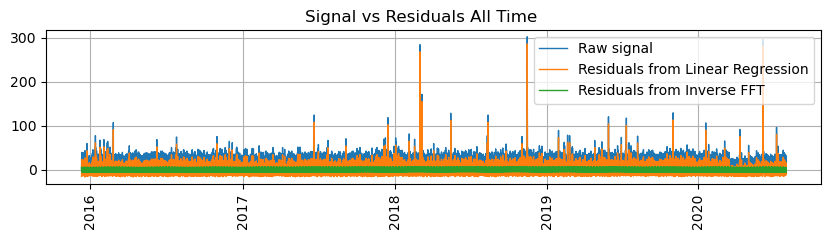

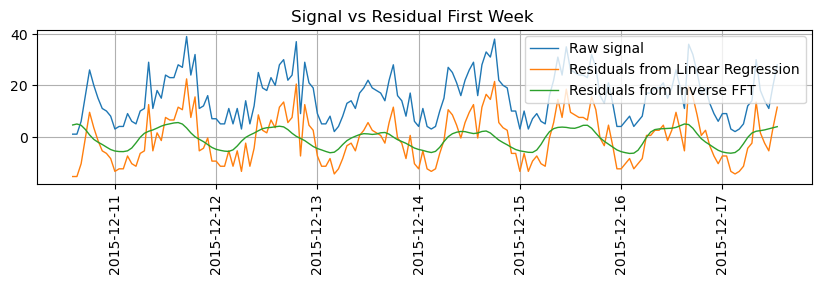

In [9]:
# fft_output that are in the list of peak frequencies
filtered_fft_output = np.array([f if i in list(peaks) else 0 for i, f in enumerate(fft_output)])
# inverse FFT of the filtered_fft_output
filtered_residuals = fft.ifft(filtered_fft_output)

# All time
plt.figure(figsize=(10, 2))
plt.plot(time, data['signal'], linewidth=1, label='Raw signal')
plt.plot(time, residuals, linewidth=1, label='Residuals from Linear Regression')
plt.plot(time, filtered_residuals.real, linewidth=1, label='Residuals from Inverse FFT')
plt.legend(loc='upper right')
plt.suptitle('Signal vs Residuals All Time')
plt.grid()
plt.xticks(rotation=90);

# First week
N = 24 * 7 # seven days
plt.figure(figsize=(10, 2))
plt.plot(time[:N], data['signal'][:N], linewidth=1, label='Raw signal')
plt.plot(time[:N], residuals[:N], linewidth=1, label='Residuals from Linear Regression')
plt.plot(time[:N], filtered_residuals[:N].real, linewidth=1, label='Residuals from Inverse FFT')
plt.legend(loc='upper right')
plt.suptitle('Signal vs Residual First Week')
plt.grid()
plt.xticks(rotation=90);

## Third Model: Incorporating FFT into Linear Regression model

Now lets incorporate our sinusoids into our initial regression. The problem with these sinusoids is that the amplitude is off. You can see in the chart above that it appears too low. This is because we did the Fourier transform on the resiudals and filtered the output down to just 13 terms.

Our initial regression just used time as its only variable, but now we can add our Fourier terms. The phase, amplitude, and frequency let us plot the wave that the FFT term corresponds to, using this formula:

$f(t) = A\cos(\omega*t + \phi)$

Where A = amplitude, $\omega$ = angular frequency = 2$\pi$ * frequency, $\phi$ = phase shift.

What we’re trying to do now is figure out what the new regression would be if we added several new variables related to these waves from the FFT.

So we go back to our original data, that had the time in seconds and the number of calls for that time, and we add several columns corresponding to each of the waves from our Fourier transform. Then we can sum these together into a new column, FT_All. This looks like:

In [10]:
for key in fourier_terms_dict.keys():
    a = fourier_terms_dict[key]['amplitude']
    w = 2 * math.pi * (fourier_terms_dict[key]['freq (1 / hour)'] / 3600)
    p = fourier_terms_dict[key]['phase']
    data[key] = data['time_sec'].apply(lambda t: a * math.cos(w*t + p))

# FT_All is the sum of FT values per row
data['FT_All'] = 0
for column in list(fourier_terms.index):
    data['FT_All'] = data['FT_All'] + data[column]

# Sample 
#data[['signal', 'time_sec', 'FT_All']  + list(fourier_terms.index)]
data[['signal', 'time_sec', 'FT_All']].head(5)

,signal,time_sec,FT_All
0,1,0.0,186012.989477
1,1,3600.0,201434.425868
2,6,7200.0,180934.346044
3,16,10800.0,114934.594786
4,26,14400.0,28738.170052


Plot FT_1 (the first Fourier term) against FT_All.

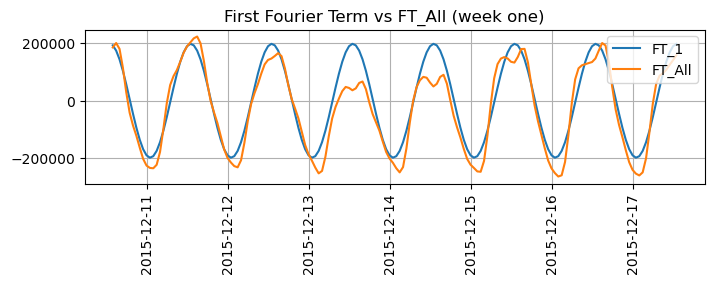

In [11]:
# Check the first Fourier term, which should have a period = 1 day
plt.figure(figsize=(8, 2))

N = 24 * 7 # seven days
plt.plot(data['time'][:N], data['FT_1'][:N], label='FT_1');
plt.plot(data['time'][:N], data['FT_All'][:N], label='FT_All');
plt.legend(loc='upper right')
plt.suptitle('First Fourier Term vs FT_All (week one)')
plt.grid()
plt.xticks(rotation=90);

### Incorporated model using FT_1
Before we just ran a regression of signal = f(time) but now we can do signal = f(time, FT_x).

#### Let's look at how well FT_1 (the first Fourier term) works for prediction.

In [12]:
X = pd.DataFrame(data[['time_sec', 'FT_1']]) 
y = pd.DataFrame(data['signal']) 

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

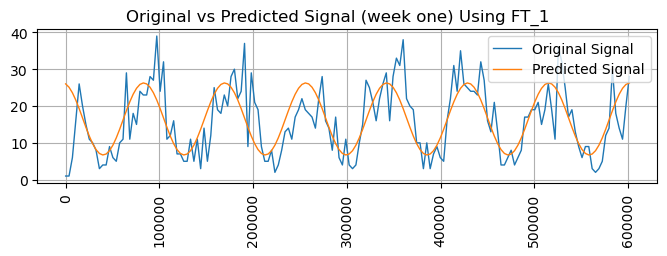

In [13]:
N = 24 * 7
plt.figure(figsize=(8, 2))
plt.plot(X['time_sec'][:N], y[:N], linewidth=1, label='Original Signal')
plt.plot(X['time_sec'][:N], y_pred[:N], linewidth=1, label='Predicted Signal')
plt.legend(loc='upper right')
plt.suptitle('Original vs Predicted Signal (week one) Using FT_1')
plt.grid()
plt.xticks(rotation=90);

In [14]:
model.score(X,y)

0.4241161368263303

### Incorporated model using FT_All

In [15]:
X = pd.DataFrame(data[['time_sec', 'FT_All']]) 
y = pd.DataFrame(data['signal']) 

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

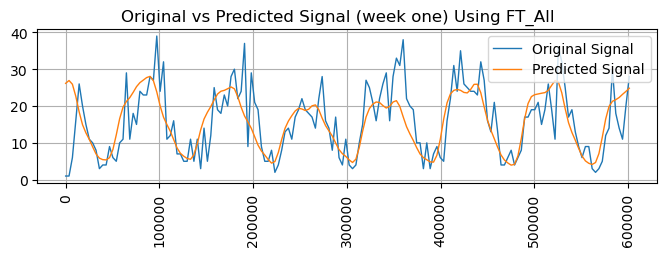

In [16]:
N = 24 * 7
plt.figure(figsize=(8, 2))
plt.plot(X['time_sec'][:N], y[:N], linewidth=1, label='Original Signal')
plt.plot(X['time_sec'][:N], y_pred[:N], linewidth=1, label='Predicted Signal')
plt.legend(loc='upper right')
plt.suptitle('Original vs Predicted Signal (week one) Using FT_All')
plt.grid()
plt.xticks(rotation=90);

In [17]:
model.score(X,y)

0.4776653053720067

Clearly, the last model is our best predictor.